In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import teotil3 as teo
from pygeos import GEOSException

alt.data_transformers.disable_max_rows()
plt.style.use("ggplot")

# Task 2.1: Update TEOTIL "core" datasets

## Part B: Summarise and combine regine-level data

From the proposal text:

> **Oppgave 2.1: Oppdatere og forbedre kjernedatasett**
> 
> Følgende datasett vil bli oppdatert:
>  * Nedbørfeltsgrenser (reginefelt fra NVE)
>  * Innsjødatabase og innsjødyp (fra NVE)
>  * Elvenett (ELVIS og Hovedelv-segmenter fra NVE)
>  * Arealbruk (AR50 fra NIBIO)
>  * Atmosfærisk avsetning av N (fra NILU)
>  * Administrative grenser (fylker og kommuner fra Geonorge)
>  
> Reginefeltene vil bli brukt til å oppsummere de andre datasettene, for eksempel ved å beregne arealbruksstatistikk og gjennomsnittlig atmosfærisk deponering for hvert reginefelt og ved å skjære fylke- og kommunegrensene. Så langt det er mulig vil arbeidsflyten være skriptet for å gjøre den repeterbar og enklere å vedlikeholde ettersom datasett oppdateres i fremtiden (selv om noe manuelt arbeid fortsatt vil være nødvendig).

## 1. Download the latest datasets

As of 2022, most datasets can be downloaded in **FGDB format**, which is cleaner and more efficient than using shapefiles. The exception is the administrative boundaries, some of which are only available in SOSI format. These therefore need processing first - see notebook `T2-1a`. All datasets are available in **ETRS89-based UTM Zone 33N**.

The following datasets can be downloaded from NVE [here](http://nedlasting.nve.no/gis/):

 * Elv
    - Hovedelv
    - Elvenett
 * Innsjø
    - Innsjø
    - Dybdedata - innsjø
 * Nedbørfelt
    - Vassdragsområder
    - Nedbørfelt til hav
    - Sidenedbørfelt
    - Regine enhet
 * Vanndirektivet
    - Select all options

Administrative boundaries can be downloaded from [Geonorge](https://www.geonorge.no/):

 * Administrative enheter fylker
 * Administrative enheter kommuner
 * Administrative enheter - historiske versjoner (for years before 2022)
 
Land cover can be downloaded from [NIBIO's Kilden](https://kart8.nibio.no/nedlasting/dashboard):

 * Arealressurskart - AR50


**All datasets were downloaded during June 2022 and added to `shared/teotil3/core_data_june_2022` on JupyterHub**.

In [3]:
# Set year of interest
reg_year = 2022  # For regine polygons
admin_year = 2022  # For fylke and kommune boundaries

In [4]:
# Get file paths
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{reg_year}"
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")
ar50_gdb = os.path.join(data_fold, "land_cover", "nibio_ar50.gdb")
admin_gpkg = os.path.join(data_fold, "administrative", "admin_data.gpkg")
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_csv = os.path.join(data_fold, "tidied", f"regine_{reg_year}_admin_{admin_year}.csv")

## 1. Basic regine properties

Summarise hydrological information from NVE's regine dataset.

In [5]:
# Basic hydrological data
reg_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="RegineEnhet")
reg_gdf = teo.io.summarise_regine_hydrology(reg_gdf)
reg_gdf.head()

regine  a_cat_land_km2  a_cat_poly_km2  upstr_a_km2  upstr_runoff_Mm3/yr  \
0    001.10            1.16        1.442790         0.00                 0.00   
1   001.1A1            1.43        1.432479       777.90               448.15   
2  001.1A20            0.34        0.340160       777.90               448.15   
3  001.1A2A           17.65       17.647822        58.96                22.97   
4  001.1A2B           41.30       41.298255        41.30                16.23   

   q_sp_m3/s/km2  runoff_mm/yr  q_cat_m3/s vassom  \
0        0.01393    439.597368    0.016159    001   
1        0.01419    447.802344    0.020292    001   
2        0.01036    326.936736    0.003522    001   
3        0.01210    381.846960    0.213565    001   
4        0.01245    392.892120    0.514185    001   

                                            geometry  
0  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4  MULTIPOLYGON (((303353.460 6552989.330, 303341...

## 2. Assign regines to fylker, kommuner and OSPAR regions

Each regine is assigned to a single fylke, kommune and OSPAR region. For regines overlapping several fylker/kommuner, the fylke/kommune with the largest proportion of the regine by area is chosen. 

**Note:** NVE's regine dataset extends beyond Norway to cover whole catchments, whereas the fylke and kommune datasets stop at the border. Some regines are therefore entirely beyond the edge of the administrative data, or have only a tiny fraction of their total area within Norway. For regines with no overlapping fylke or kommune, I have assigned `fylnr = komnr = -1`.

In [6]:
# Assign administrative regions
reg_gdf = teo.io.assign_regines_to_administrative_units(reg_gdf, admin_gpkg, admin_year)
reg_gdf = teo.io.assign_regines_to_ospar_regions(reg_gdf)
reg_gdf.head()

Processing kommuner
    356 kommuner.
    23796 regines.
    31209 intersected polygons.
    23513 regines assigned to kommuner.
Processing fylker
    11 kommuner.
    23796 regines.
    24532 intersected polygons.
    23513 regines assigned to fylker.


regine  a_cat_land_km2  a_cat_poly_km2  upstr_a_km2  upstr_runoff_Mm3/yr  \
0    001.10            1.16        1.442790         0.00                 0.00   
1   001.1A1            1.43        1.432479       777.90               448.15   
2  001.1A20            0.34        0.340160       777.90               448.15   
3  001.1A2A           17.65       17.647822        58.96                22.97   
4  001.1A2B           41.30       41.298255        41.30                16.23   

   q_sp_m3/s/km2  runoff_mm/yr  q_cat_m3/s vassom komnr fylnr ospar_region  \
0        0.01393    439.597368    0.016159    001  3001    30    Skagerrak   
1        0.01419    447.802344    0.020292    001  3001    30    Skagerrak   
2        0.01036    326.936736    0.003522    001  3001    30    Skagerrak   
3        0.01210    381.846960    0.213565    001  3001    30    Skagerrak   
4        0.01245    392.892120    0.514185    001  3001    30    Skagerrak   

                                            geometry  
0  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4  MULTIPOLYGON (((303353.460 6552989.330, 303341...

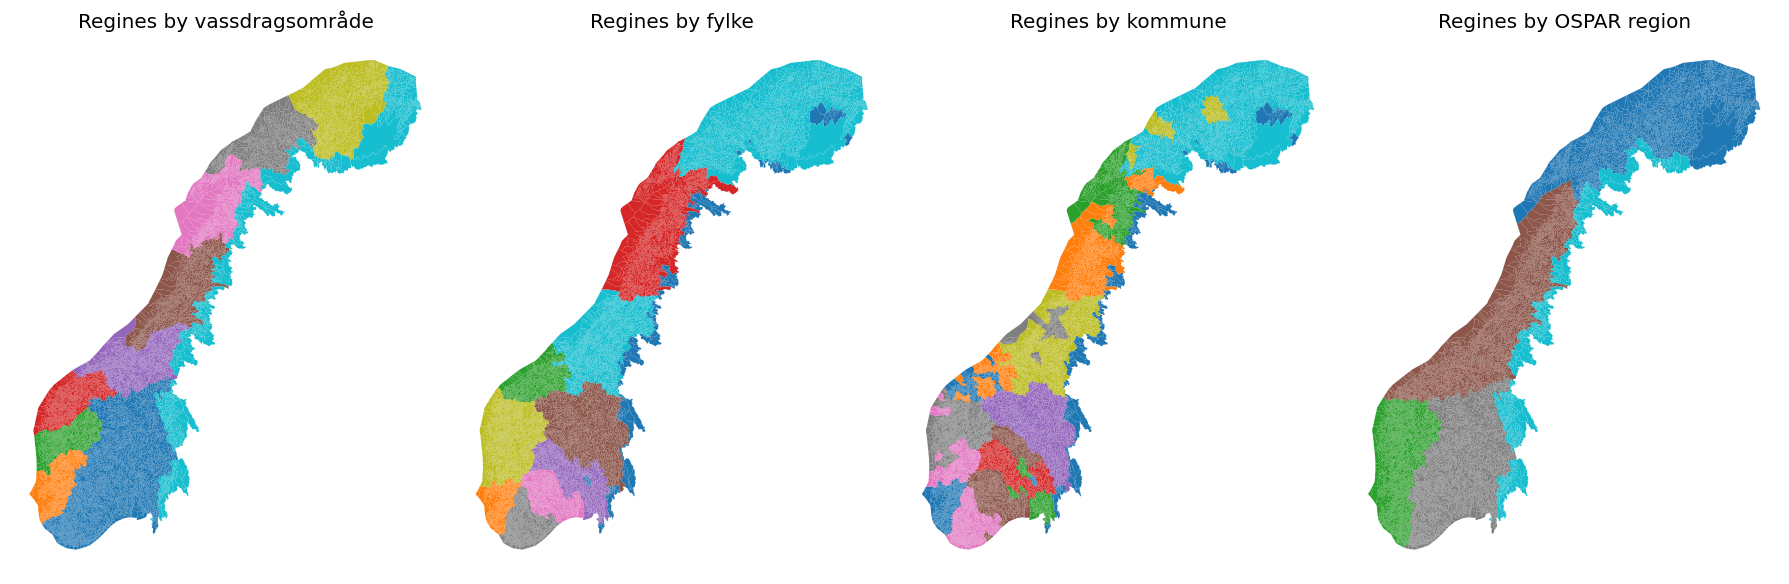

In [7]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
reg_gdf.plot(column="vassom", categorical=True, ax=axes[0])
reg_gdf.plot(column="fylnr", categorical=True, ax=axes[1])
reg_gdf.plot(column="komnr", categorical=True, ax=axes[2])
reg_gdf.plot(column="ospar_region", categorical=True, ax=axes[3])
axes[0].set_title("Regines by vassdragsområde")
axes[1].set_title("Regines by fylke")
axes[2].set_title("Regines by kommune")
axes[3].set_title("Regines by OSPAR region")
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()

## 3. Land cover proportions

TEOTIL currently considers the following broad land cover classes:

 * Urban
 * Woodland
 * Agricultural
 * Upland
 * Glacier
 * Sea
 * Lake

**Note:** As above, some regines lie entirely outside of Norway and are therefore not covered by AR50. I have classed these as 100% "other/not mapped" (`artype = 99`) in the code below.

In [8]:
%%time

# Calculate land cover proportions
ar50_gdf = gpd.read_file(ar50_gdb, driver="fileGDB", layer="org_ar_ar50_flate")
reg_gdf = teo.io.calculate_ar50_land_cover_proportions(reg_gdf, ar50_gdf)
reg_gdf.head()

Reclassifying...
Reprojecting to equal area...
Intersecting polygons...
Aggregating...
CPU times: user 19min 43s, sys: 25.2 s, total: 20min 8s
Wall time: 20min 41s


regine  a_cat_land_km2  a_cat_poly_km2  upstr_a_km2  upstr_runoff_Mm3/yr  \
0    001.10            1.16        1.442790         0.00                 0.00   
1   001.1A1            1.43        1.432479       777.90               448.15   
2  001.1A20            0.34        0.340160       777.90               448.15   
3  001.1A2A           17.65       17.647822        58.96                22.97   
4  001.1A2B           41.30       41.298255        41.30                16.23   

   q_sp_m3/s/km2  runoff_mm/yr  q_cat_m3/s vassom komnr  ... a_agri_km2  \
0        0.01393    439.597368    0.016159    001  3001  ...   0.000000   
1        0.01419    447.802344    0.020292    001  3001  ...   0.000000   
2        0.01036    326.936736    0.003522    001  3001  ...   0.000000   
3        0.01210    381.846960    0.213565    001  3001  ...   1.895549   
4        0.01245    392.892120    0.514185    001  3001  ...   1.573851   

  a_glacier_km2  a_lake_km2   a_other_km2  a_sea_km2  a_upland_km2  \
0           0.0    0.000013  3.116485e-01   0.281940      0.000000   
1           0.0    0.048098  2.223036e-03   0.000067      0.004615   
2           0.0    0.036623  0.000000e+00   0.000045      0.000000   
3           0.0    0.122567  0.000000e+00   0.000000      0.467374   
4           0.0    7.513687  1.563194e-13   0.000000      2.250799   

   a_urban_km2  a_wood_km2  ar50_tot_a_km2  \
0     0.000000    0.849188        0.849201   
1     0.000000    1.377476        1.430189   
2     0.000000    0.303492        0.340114   
3     0.131585   15.030746       17.647822   
4     0.161524   29.798394       41.298255   

                                            geometry  
0  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4  MULTIPOLYGON (((303353.460 6552989.330, 303341...  

[5 rows x 22 columns]

## 4. NVE lake areas

For comparison with AR50, it seems sensible to summarise lake areas per regine from the NVE dataset as well.

**Note:** In many cases, especially in the far north of the country, areas identified as "lakes" by NVE are classed as "myr" in AR50 (`artype = 60`). I'm not sure how best to resolve this at present.

In [9]:
# Get lake areas from NVE data
lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo")
reg_gdf = teo.io.calculate_nve_regine_lake_areas(reg_gdf, lake_gdf)
reg_gdf.head()

regine  a_cat_land_km2  a_cat_poly_km2  upstr_a_km2  upstr_runoff_Mm3/yr  \
0    001.10            1.16        1.442790         0.00                 0.00   
1   001.1A1            1.43        1.432479       777.90               448.15   
2  001.1A20            0.34        0.340160       777.90               448.15   
3  001.1A2A           17.65       17.647822        58.96                22.97   
4  001.1A2B           41.30       41.298255        41.30                16.23   

   q_sp_m3/s/km2  runoff_mm/yr  q_cat_m3/s vassom komnr  ... a_glacier_km2  \
0        0.01393    439.597368    0.016159    001  3001  ...           0.0   
1        0.01419    447.802344    0.020292    001  3001  ...           0.0   
2        0.01036    326.936736    0.003522    001  3001  ...           0.0   
3        0.01210    381.846960    0.213565    001  3001  ...           0.0   
4        0.01245    392.892120    0.514185    001  3001  ...           0.0   

  a_lake_km2   a_other_km2  a_sea_km2  a_upland_km2  a_urban_km2  a_wood_km2  \
0   0.000013  3.116485e-01   0.281940      0.000000     0.000000    0.849188   
1   0.048098  2.223036e-03   0.000067      0.004615     0.000000    1.377476   
2   0.036623  0.000000e+00   0.000045      0.000000     0.000000    0.303492   
3   0.122567  0.000000e+00   0.000000      0.467374     0.131585   15.030746   
4   7.513687  1.563194e-13   0.000000      2.250799     0.161524   29.798394   

   ar50_tot_a_km2  a_lake_nve_km2  \
0        0.849201        0.000000   
1        1.430189        0.043955   
2        0.340114        0.000000   
3       17.647822        0.186340   
4       41.298255        7.344123   

                                            geometry  
0  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4  MULTIPOLYGON (((303353.460 6552989.330, 303341...  

[5 rows x 23 columns]

## 5. Assign regine retention

Based on work from Tasks 2.2 to 2.5, the code below assigns retention and transmission coefficients for each parameter of interest to each regine.

In [10]:
reg_gdf = teo.io.assign_regine_retention(reg_gdf, regine_col="regine", dtm_res=10)
reg_gdf.head()

regine  a_cat_land_km2  a_cat_poly_km2  upstr_a_km2  upstr_runoff_Mm3/yr  \
0    001.10            1.16        1.442790         0.00                 0.00   
1   001.1A1            1.43        1.432479       777.90               448.15   
2  001.1A20            0.34        0.340160       777.90               448.15   
3  001.1A2A           17.65       17.647822        58.96                22.97   
4  001.1A2B           41.30       41.298255        41.30                16.23   

   q_sp_m3/s/km2  runoff_mm/yr  q_cat_m3/s vassom komnr  ... a_upland_km2  \
0        0.01393    439.597368    0.016159    001  3001  ...     0.000000   
1        0.01419    447.802344    0.020292    001  3001  ...     0.004615   
2        0.01036    326.936736    0.003522    001  3001  ...     0.000000   
3        0.01210    381.846960    0.213565    001  3001  ...     0.467374   
4        0.01245    392.892120    0.514185    001  3001  ...     2.250799   

  a_urban_km2  a_wood_km2  ar50_tot_a_km2  a_lake_nve_km2  \
0    0.000000    0.849188        0.849201        0.000000   
1    0.000000    1.377476        1.430189        0.043955   
2    0.000000    0.303492        0.340114        0.000000   
3    0.131585   15.030746       17.647822        0.186340   
4    0.161524   29.798394       41.298255        7.344123   

                                            geometry  trans_orig-totp  \
0  MULTIPOLYGON (((297006.830 6543966.950, 297169...         1.000000   
1  MULTIPOLYGON (((297505.440 6543157.790, 297543...         1.000000   
2  MULTIPOLYGON (((297770.368 6543429.036, 297787...         1.000000   
3  MULTIPOLYGON (((299678.370 6544460.320, 299667...         1.000000   
4  MULTIPOLYGON (((303353.460 6552989.330, 303341...         0.114735   

   trans_orig-totn  ret_orig-totp  ret_orig-totn  
0         1.000000       0.000000       0.000000  
1         1.000000       0.000000       0.000000  
2         1.000000       0.000000       0.000000  
3         1.000000       0.000000       0.000000  
4         0.708605       0.885265       0.291395  

[5 rows x 27 columns]

## 6. Save dataset

The final regine dataset can now be saved for use later.

In [11]:
# Save
teo.io.geodataframe_to_geopackage(
    reg_gdf,
    teo_gpkg,
    f"regine_{reg_year}_admin_{admin_year}",
    attrib_tab_csv=reg_csv,
)

## 7. Basic checking

In [12]:
# Read saved data
reg_gdf = gpd.read_file(
    teo_gpkg, layer=f"regine_{reg_year}_admin_{admin_year}", driver="GPKG"
)

# Check for NaN
pd.isna(reg_gdf).sum(axis="rows")

regine                 0
a_cat_land_km2         0
a_cat_poly_km2         0
upstr_a_km2            0
upstr_runoff_Mm3/yr    0
q_sp_m3/s/km2          0
runoff_mm/yr           0
q_cat_m3/s             0
vassom                 0
komnr                  0
fylnr                  0
ospar_region           0
a_agri_km2             0
a_glacier_km2          0
a_lake_km2             0
a_other_km2            0
a_sea_km2              0
a_upland_km2           0
a_urban_km2            0
a_wood_km2             0
ar50_tot_a_km2         0
a_lake_nve_km2         0
trans_orig-totp        0
trans_orig-totn        0
ret_orig-totp          0
ret_orig-totn          0
geometry               0
dtype: int64

### 7.1. Compare NVE's regine areas to totals from AR50

`ar50_tot_a_km2` is defined as the sum of AR50 classes that are not `sea` or `other`. 

Note that most of the differences are along Norway's eastern border, where the regines extend into Sweden/Finland, but AR50 stops. This is why `a_cat_land_km2` is always larger than `ar50_tot_a_km2`.

In [13]:
# plt.plot(reg_gdf["a_cat_land_km2"], reg_gdf["ar50_tot_a_km2"], "ro")
# plt.plot(reg_gdf["a_cat_land_km2"], reg_gdf["a_cat_land_km2"], "k-")
# plt.xlabel("NVE regine area (km2)")
# plt.ylabel("AR50 regine area (km2)")

In [14]:
alt.Chart(reg_gdf[["regine", "a_cat_land_km2", "ar50_tot_a_km2"]]).mark_circle(
    size=60
).encode(
    x="a_cat_land_km2",
    y="ar50_tot_a_km2",
    # color='Origin',
    tooltip=["regine", "a_cat_land_km2", "ar50_tot_a_km2"],
).interactive()

alt.Chart(...)

### 7.2. Compare NVE's lake areas to totals from AR50

There are some surprising differences between NVE's lakes database and AR50. In particular:

 * Areas classified as lakes by NVE are often designated "myr" in AR50 (especially in the far north)
 * There are some obvious lakes/large bodies of freshwater missing from NVE's database. For example, the area [here](https://www.google.com/maps/search/?api=1&query=61.86141262616309,8.515057011399492) is not a lake according to NVE

In [15]:
# plt.plot(reg_gdf["a_lake_nve_km2"], reg_gdf["a_lake_km2"], "ro")
# plt.plot(reg_gdf["a_lake_nve_km2"], reg_gdf["a_lake_nve_km2"], "k-")
# plt.xlabel("NVE regine total lake area (km2)")
# plt.ylabel("AR50 regine total freshwater area (km2)")

In [16]:
alt.Chart(reg_gdf[["regine", "a_lake_nve_km2", "a_lake_km2"]]).mark_circle(
    size=60
).encode(
    x="a_lake_nve_km2",
    y="a_lake_km2",
    # color='Origin',
    tooltip=["regine", "a_lake_nve_km2", "a_lake_km2"],
).interactive()

alt.Chart(...)

## 8. Process historic administrative boundaries

The code below intersects the 2022 regine boundaries with the historic fylke and kommune boundaries from 2003 to 2022. This produces a regine dataset with multiple columns named `komnr_{year}` and `fylnr_{year}`, instead of just `komnr` and `fylnr`, as above.

**Note:** There seems to be an issue with the administrative data for some years, related to [this](https://github.com/shapely/shapely/issues/1364) GEOS problem. I have not investigated in detail yet; the code below simply skips years where GEOS cannot handle the data correctly.

In [17]:
%%time

# Years of interest
reg_year = 2022
admin_years = range(2003, 2023)

# Build file paths
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{reg_year}"
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")
ar50_gdb = os.path.join(data_fold, "land_cover", "nibio_ar50.gdb")
admin_gpkg = os.path.join(data_fold, "administrative", "admin_data.gpkg")
teo_gpkg = os.path.join(data_fold, "tidied", f"teotil3_data.gpkg")

# Read basic datasets
reg_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="RegineEnhet")
ar50_gdf = gpd.read_file(ar50_gdb, driver="fileGDB", layer="org_ar_ar50_flate")
lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo")

# Standard processing
gdf = teo.io.summarise_regine_hydrology(reg_gdf)
gdf = teo.io.assign_regines_to_ospar_regions(gdf)
gdf = teo.io.calculate_ar50_land_cover_proportions(gdf, ar50_gdf)
gdf = teo.io.calculate_nve_regine_lake_areas(gdf, lake_gdf)
gdf = teo.io.assign_regine_retention(gdf, regine_col="regine", dtm_res=10)

# Process historic admin boundaries
for admin_year in admin_years:
    print("####################################################################")
    print(f"Processing {admin_year}...")
    try:
        gdf = teo.io.assign_regines_to_administrative_units(gdf, admin_gpkg, admin_year)
        gdf.rename(
            {"komnr": f"komnr_{admin_year}", "fylnr": f"fylnr_{admin_year}"},
            axis="columns",
            inplace=True,
        )
    except GEOSException:
        print("WARNING:", admin_year, "is affected by a problem with GEOS.")
        
# Save
layer = f"regine_{reg_year}"
reg_csv = os.path.join(data_fold, "tidied", f"{layer}.csv")
teo.io.geodataframe_to_geopackage(
    gdf,
    teo_gpkg,
    layer,
    attrib_tab_csv=reg_csv,
)

gdf.head()

Reclassifying...
Reprojecting to equal area...
Intersecting polygons...
Aggregating...
####################################################################
Processing 2003...
Processing kommuner
####################################################################
Processing 2004...
Processing kommuner
####################################################################
Processing 2005...
Processing kommuner
####################################################################
Processing 2006...
Processing kommuner
    431 kommuner.
    23796 regines.
    31961 intersected polygons.
    23513 regines assigned to kommuner.
Processing fylker
    19 kommuner.
    23796 regines.
    25030 intersected polygons.
    23513 regines assigned to fylker.
####################################################################
Processing 2007...
Processing kommuner
####################################################################
Processing 2008...
Processing kommuner
    430 kommuner.
    23796 regi

regine  a_cat_land_km2  a_cat_poly_km2  upstr_a_km2  upstr_runoff_Mm3/yr  \
0    001.10            1.16        1.442790         0.00                 0.00   
1   001.1A1            1.43        1.432479       777.90               448.15   
2  001.1A20            0.34        0.340160       777.90               448.15   
3  001.1A2A           17.65       17.647822        58.96                22.97   
4  001.1A2B           41.30       41.298255        41.30                16.23   

   q_sp_m3/s/km2  runoff_mm/yr  q_cat_m3/s vassom ospar_region  ...  \
0        0.01393    439.597368    0.016159    001    Skagerrak  ...   
1        0.01419    447.802344    0.020292    001    Skagerrak  ...   
2        0.01036    326.936736    0.003522    001    Skagerrak  ...   
3        0.01210    381.846960    0.213565    001    Skagerrak  ...   
4        0.01245    392.892120    0.514185    001    Skagerrak  ...   

   fylnr_2018  komnr_2019  fylnr_2019  komnr_2020  fylnr_2020  komnr_2021  \
0          01        0101          01        3001          30        3001   
1          01        0101          01        3001          30        3001   
2          01        0101          01        3001          30        3001   
3          01        0101          01        3001          30        3001   
4          01        0101          01        3001          30        3001   

   fylnr_2021  komnr_2022  fylnr_2022  \
0          30        3001          30   
1          30        3001          30   
2          30        3001          30   
3          30        3001          30   
4          30        3001          30   

                                            geometry  
0  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4  MULTIPOLYGON (((303353.460 6552989.330, 303341...  

[5 rows x 53 columns]